**IT4653: Học sâu và ứng dụng**
(Deep Learning and Its Application) - 2023.1

**GVHD:** PGS. TS. Nguyễn Thị Kim Anh

----
Trong notebook này, chúng em thực hiện huấn luyện mô hình CRNN (CNN + RNN) cho tác vụ nhận dạng chữ viết tay tiếng Việt. Mô hình huấn luyện sử dụng hàm lỗi CTC (Connectionist Temporal Classification).

# ![CRNN-model](https://www.researchgate.net/publication/355102486/figure/fig1/AS:1076640469778433@1633702499618/Schematic-diagram-of-CRNN-network-structure.ppm)

Trước hết, ta import các thư viện cần thiết.

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Đọc và chia dữ liệu thành các tập train, validation và test
Dữ liệu sử dụng để huấn luyện được lấy từ cuộc thi SOICT Hackathon 2023, do BKAI tổ chức.

In [2]:
label_file = '/kaggle/input/viet-ocr/train_gt.txt'

with open(label_file, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    data = [line.strip().split() for line in lines]

df = pd.DataFrame(data, columns=['image', 'label'])

Dữ liệu có 103000 ảnh, mỗi hình ảnh chứa ảnh chụp viết tay của một từ tiếng Việt, lưu dưới dạng .jpg. Ngoài ra còn một tệp train_gt.txt chứa tên ảnh và nhãn tương ứng là từ trong ảnh đó.

Dưới đây là một số ví dụ về dữ liệu:

In [3]:
df.head() # Dữ liệu file train_gt.txt

,image,label
0,train_img_0.jpg,Thỗn
1,train_img_1.jpg,May-So
2,train_img_2.jpg,nhẹn
3,train_img_3.jpg,hàu
4,train_img_4.jpg,Quấy


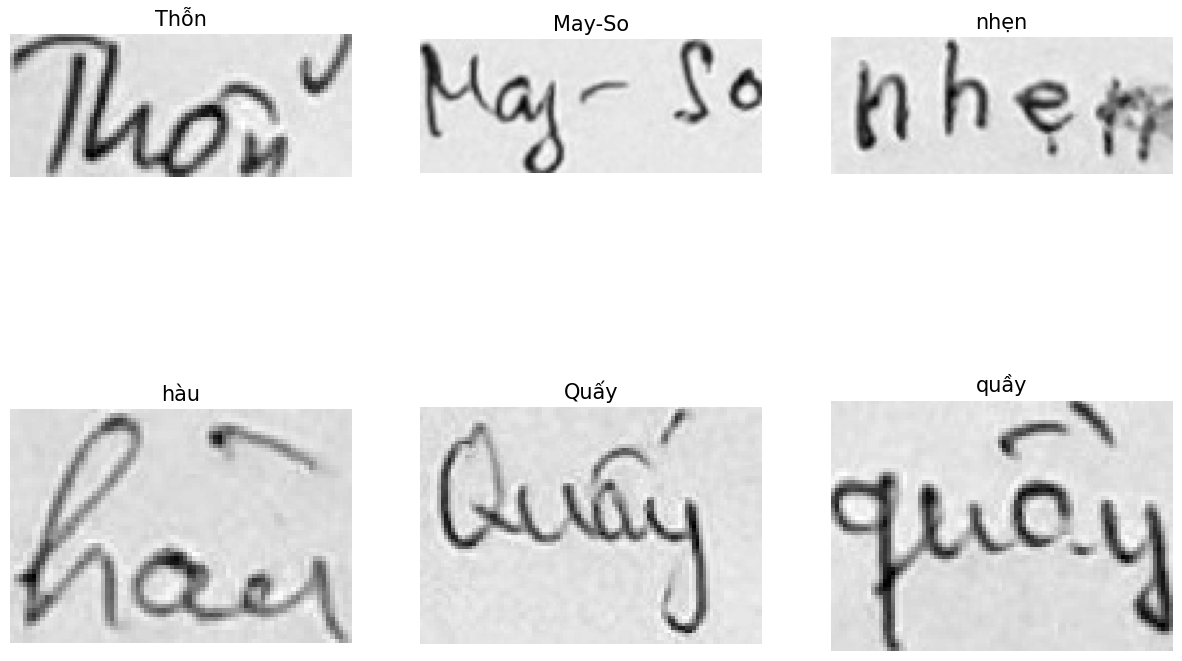

In [4]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/viet-ocr/training_data/new_train/'+df.loc[i, 'image']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(df.loc[i, 'label'], fontsize=15)
    plt.axis('off')

Sử dụng hàm *train_test_split* trong thư viện *sklearn* để chia dữ liệu thành các tập train, validation, test với tỉ lệ 7: 1: 2. 

Bởi vì **giới hạn bộ nhớ của Kaggle**, nên ở đây chúng em sẽ chia tập nhãn (trong tập nhãn có chứa tên ảnh, khi muốn xử lý chỉ cần gọi đến đường dẫn).

In [5]:
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(temp_data, test_size=0.33, random_state=42)

train_data.to_csv('/kaggle/working/train.csv', index=False, encoding='utf-8')
val_data.to_csv('/kaggle/working/val.csv', index=False, encoding='utf-8')
test_data.to_csv('/kaggle/working/test.csv', index=False, encoding='utf-8')

In [6]:
train = pd.read_csv('/kaggle/working/train.csv')
valid = pd.read_csv('/kaggle/working/val.csv')

## Làm sạch dữ liệu
Tại bước này, kiểm tra và xóa những ảnh không có nhãn tương ứng.

In [7]:
print("Nhãn rỗng trong tập train: ", train['label'].isnull().sum())
print("Nhãn rỗng trong tập validation: ", valid['label'].isnull().sum())

Nhãn rỗng trong tập train:  10
Nhãn rỗng trong tập validation:  3


In [8]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

Cập nhật lại chỉ số các ảnh (từ 0, 1,...) sau khi loại bỏ rỗng.

In [9]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

## Tiền xử lý và chuẩn bị ảnh cho việc huấn luyện
* Các hình ảnh được chuyển đổi thành ảnh xám và được resize thành cỡ (rộng = 256, cao = 64).  
* Chiều rộng và chiều cao được cắt nếu chúng tương ứng lớn hơn 256 và 64. Nếu nhỏ hơn, hình ảnh được đệm bằng các pixel trắng. Sau đó, hình ảnh được xoay theo chiều kim đồng hồ để đưa về đúng cỡ (256, 64).
* Hình ảnh sau đó được chuẩn hóa pixel trên [0,1]

In [10]:
def preprocess(img):
    (h, w) = img.shape[:2]
    
    final_img = np.ones([64, 256])*255 # tạo ảnh trắng
    
    # phần để cắt ảnh
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

Vì có một số thực nghiệm (ví dụ: tăng sinh ảnh,...), và với giới hạn bộ nhớ của Kaggle, nên chúng em chỉ thực hiện huấn luyện trên 50000 ảnh và 5000 ảnh dùng để tối ưu (validation).

In [11]:
train_size = 50000
valid_size = 5000

In [12]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/viet-ocr/training_data/new_train/'+train.loc[i, 'image']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [13]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/viet-ocr/training_data/new_train/'+valid.loc[i, 'image']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

Biến đổi train_x và valid_x thành hai mảng NumPy, sử dụng mảng này để làm dữ liệu đầu vào cho mô hình.

In [14]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

## Chuẩn bị nhãn cho hàm lỗi CTC
Trong tác vụ nhận diện chữ viết tay, đầu ra sẽ là một câu, nhưng chưa hoàn chỉnh vì có các ký tự lặp lại như "heelllo", "toooo", ... hay các chữ có những khoảng trống (blank) như "he l l oo", "t o o", ... 

Do đó, để cho ra được một câu hoàn chỉnh thì ta cần phải căn chỉnh lại đầu ra ấy, loại bỏ các ký tự lặp lại và khoảng trống. Vấn đề này được gọi là **alignment problem** và nó được giải quyết bằng CTC.

Bài báo về hàm lỗi CTC: [CTC Loss](https://www.cs.toronto.edu/~graves/icml_2006.pdf).

Trước hết sẽ duyệt toàn bộ nhãn có trong tập huấn luyện để lấy ra bảng ký tự (kể cả ký tự -, space, ').

In [15]:
char_list= set()
for label in train['label']:
    char_list.update(set(label))
char_list=sorted(char_list)

In [16]:
alphabets = "".join(char_list)
print(f'Số ký tự: {len(char_list)}\n\nChuỗi ký tự:\n{alphabets}')

Số ký tự: 187

Chuỗi ký tự:
-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ


187 ký tự cần huấn luyện. Tiếp theo, các nhãn phải được chuyển thành các số đại diện cho mỗi ký tự trong bộ dữ liệu huấn luyện.

(CTC blank là một kí tự đặc biệt trong CTC, ký hiệu số bằng -1)

In [17]:
max_str_len = 20 # độ dài nhãn huấn luyện tối đa
num_of_characters = len(alphabets) + 1 # +1 vì ký tự CTC pseudo blank
num_of_timestamps = 64 # độ dài nhãn dự đoán tối đa

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [18]:
name = 'Nguyễn Văn Thọ'
print(name, '\n',label_to_num(name))

Nguyễn Văn Thọ 
 [ 14  33  47  51 134  40  -1  22  86  40  -1  20  34 142]


* **train_y** chứa các nhãn đúng của ảnh đã được chuyển đổi thành số và được đệm thêm -1 (CTC blank) nếu như độ dài nhỏ hơn max_str_len, sao cho độ dài của mỗi nhãn bằng với max_str_len.
* **train_label_len** chứa độ dài của mỗi nhãn đúng (không đệm).
* **train_input_len** chứa độ dài của mỗi nhãn dự đoán. Độ dài của tất cả các nhãn dự đoán là hằng số, tức là số **timestamp - 2.**
* **train_output** là một dummy output cho hàm lỗi CTC.

In [19]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'label'])
    train_y[i, 0:len(train.loc[i, 'label'])]= label_to_num(train.loc[i, 'label'])  

In [20]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'label'])
    valid_y[i, 0:len(valid.loc[i, 'label'])]= label_to_num(valid.loc[i, 'label'])    

Kiểm tra lại tính đúng đắn của các bước vừa thực hiện.

In [21]:
print('Nhãn đúng: ',train.loc[50, 'label'] , '\ntrain_y : ',train_y[50],'\ntrain_label_len : ',train_label_len[50], 
      '\ntrain_input_len : ', train_input_len[50])

Nhãn đúng:  CHƯỢC 
train_y :  [  3.   8.  95. 163.   3.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
  -1.  -1.  -1.  -1.  -1.  -1.] 
train_label_len :  [5.] 
train_input_len :  [62.]


## Xây dựng mô hình
Sử dụng mô hình CRNN, cụ thể:
![CRNN-model](https://www.researchgate.net/publication/355102486/figure/fig1/AS:1076640469778433@1633702499618/Schematic-diagram-of-CRNN-network-structure.ppm)

* Convolution layers: Trích chọn các đặc trưng của ảnh. Đầu ra là một chuỗi các vec-tơ đặc trưng.
* Recurrent layers: Dự đoán phân bố nhãn cho từng frame (per-frame prediction).
* Transcription layers chuyển per-frame prediction của RNN thành từ dự đoán (đầu ra mô hình).

In [22]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)

inner = Conv2D(256, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv6', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv7', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)

inner = Conv2D(512, (3, 3), padding='same', name='conv8', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv9', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv10', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)

inner = Conv2D(512, (3, 3), padding='same', name='conv11', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv12', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv13', kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max5')(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)

y_pred = Activation('softmax', name='softmax')(inner)


model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 64)       640       
                                                                 
 batch_normalization (Batch  (None, 256, 64, 64)       256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 64, 64)       0         
                                                                 
 conv2 (Conv2D)              (None, 256, 64, 64)       36928     
                                                                 
 batch_normalization_1 (Bat  (None, 256, 64, 64)       256       
 chNormalization)                                            

In [23]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [24]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [25]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, save_weights_only=True)
]

In [26]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer= Adam(lr = 0.0001))

history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=40, batch_size=128, callbacks = my_callbacks)

Epoch 1/40
391/391 [==============================] - 243s 540ms/step - loss: 17.9763 - val_loss: 15.8138
Epoch 2/40
391/391 [==============================] - 202s 518ms/step - loss: 13.3763 - val_loss: 12.4985
Epoch 3/40
391/391 [==============================] - 203s 519ms/step - loss: 9.7833 - val_loss: 9.6962
Epoch 4/40
391/391 [==============================] - 203s 520ms/step - loss: 6.3028 - val_loss: 5.9080
Epoch 5/40
391/391 [==============================] - 203s 520ms/step - loss: 4.4480 - val_loss: 23.4438
Epoch 6/40
391/391 [==============================] - 203s 520ms/step - loss: 3.3609 - val_loss: 3.9949
Epoch 7/40
391/391 [==============================] - 203s 520ms/step - loss: 2.7481 - val_loss: 3.5361
Epoch 8/40
391/391 [==============================] - 203s 520ms/step - loss: 2.3123 - val_loss: 2.6699
Epoch 9/40
391/391 [==============================] - 203s 520ms/step - loss: 1.9567 - val_loss: 2.3728
Epoch 10/40
391/391 [==============================] - 203s

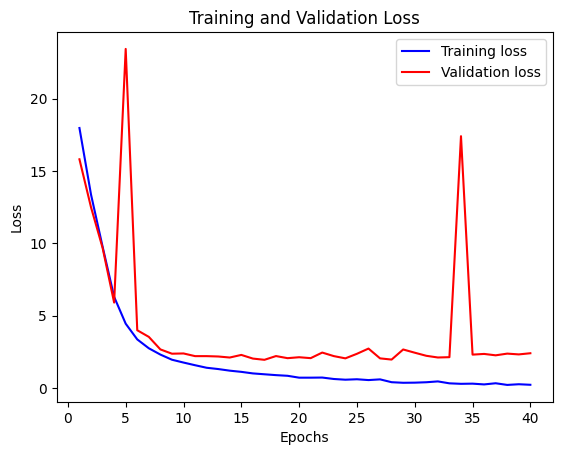

In [27]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Vẽ biểu đồ
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Hiển thị biểu đồ
plt.show()

In [28]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

157/157 [==============================] - 10s 45ms/step


Đánh giá hiệu năng trên tập validation với 2 trường hợp
- Phân biệt chữ in hoa in thường
- Không phân biệt chữ in hoa in thường

In [29]:
y_true = valid.loc[0:valid_size, 'label']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 76.97%
Correct words predicted      : 60.00%


In [30]:
y_true = valid.loc[0:valid_size, 'label']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i].lower()
    tr = y_true[i].lower()
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 78.14%
Correct words predicted      : 61.86%


1/1 [==============================] - 0s 27ms/step


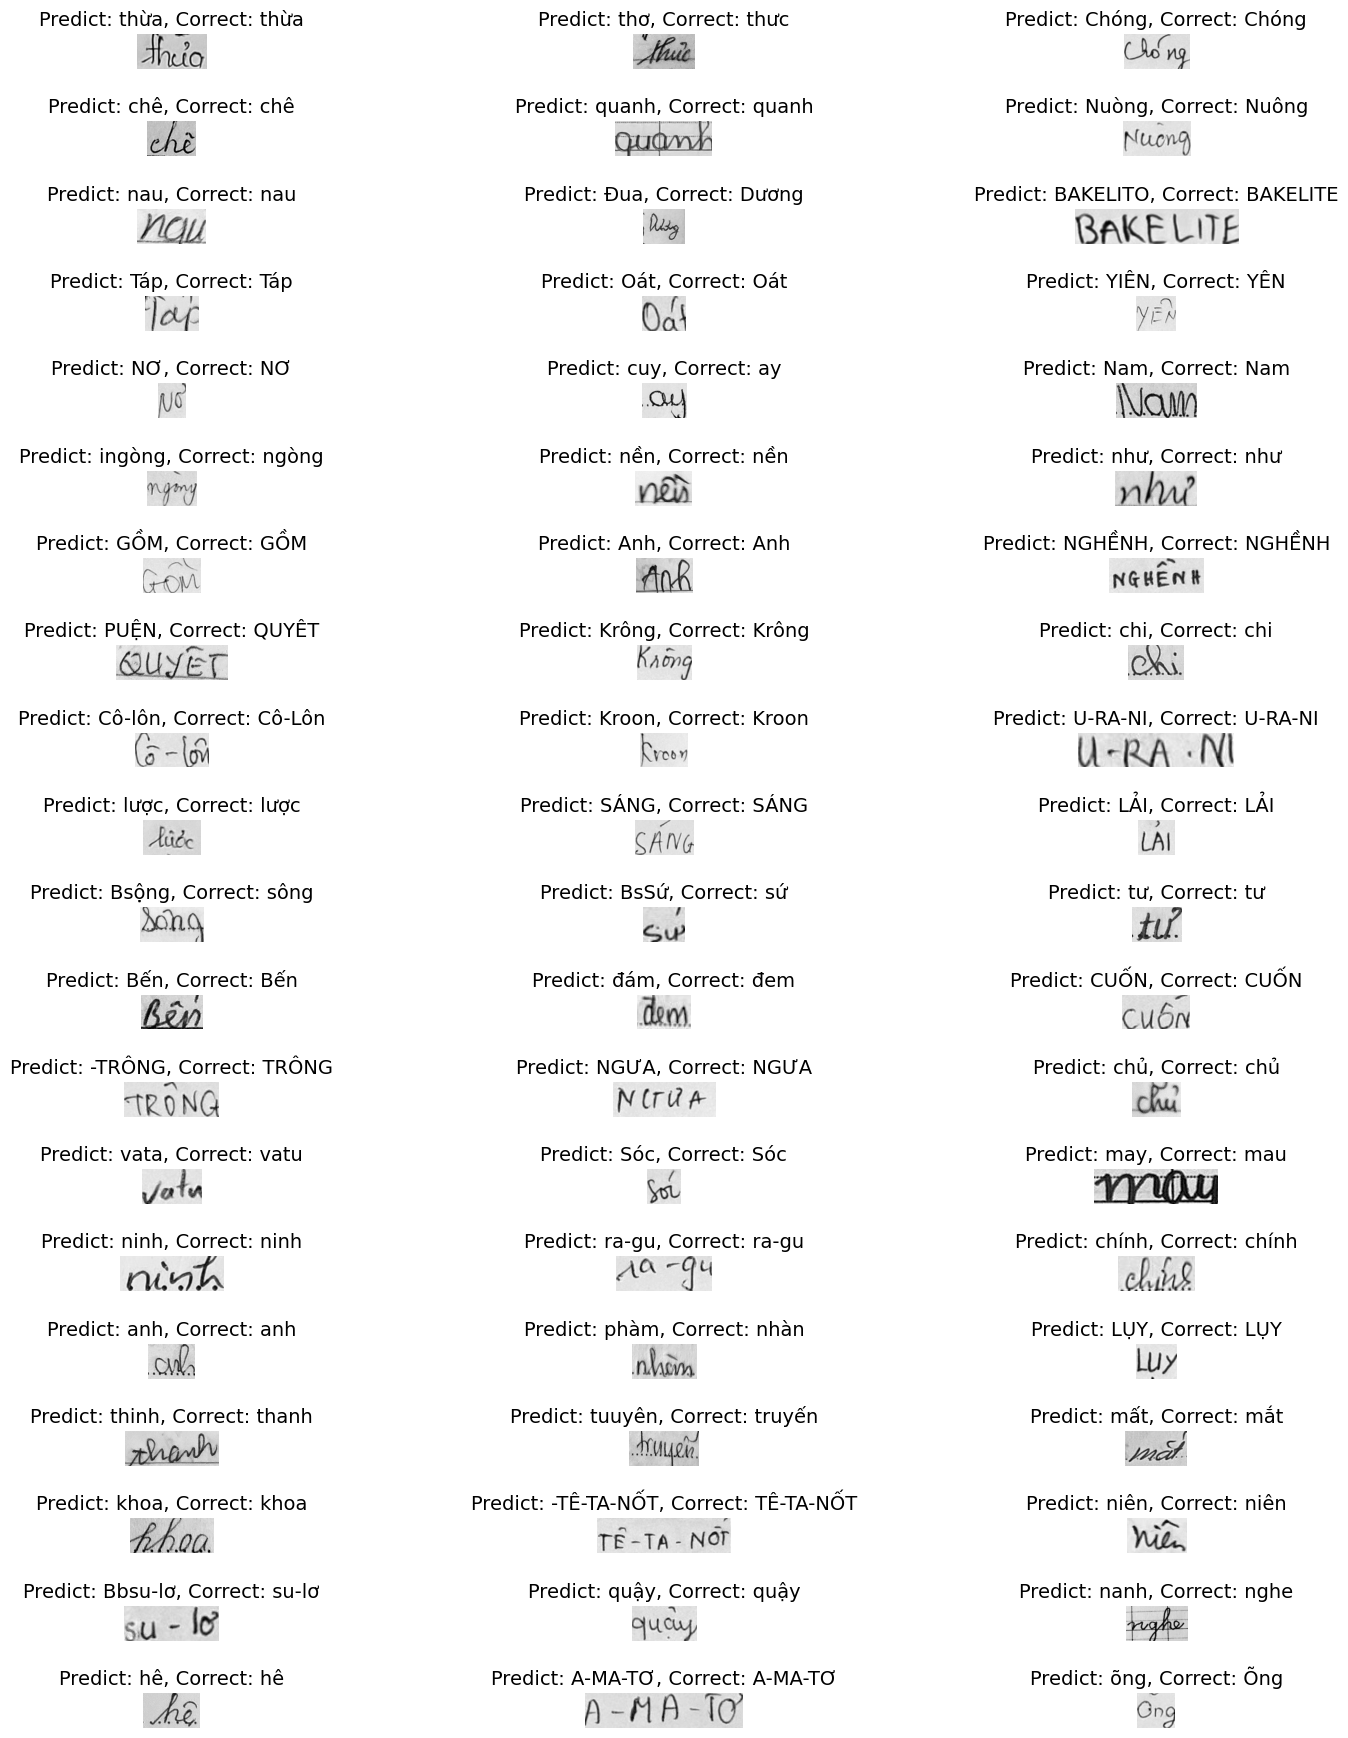

In [31]:
test = pd.read_csv('/kaggle/working/test.csv')

plt.figure(figsize=(18, 22))
for i in range(60):
    ax = plt.subplot(20, 3, i+1)
    img_dir = '/kaggle/input/viet-ocr/training_data/new_train/'+test.loc[i, 'image']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(-1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(f"Predict: {num_to_label(decoded[0])}, Correct: {test.loc[i, 'label']}", fontsize=14)
    plt.subplots_adjust(hspace=1.5)
    plt.axis('off')